In [ ]:
import pandas as pd

passengers = pd.read_csv("../Data/train.csv")
passengers.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [85]:
from sklearn.model_selection import train_test_split

X = passengers.drop(columns=["Survived"])
Y = passengers["Survived"]
x_train, x_test, y_train, y_test = train_test_split(X, Y, shuffle=True, test_size=0.1)

In [86]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer


class DropColumnTranformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.drop(columns=self.columns, axis=1, errors="ignore")
    
    def get_feature_names_out(self, input_features=None):
        return None
    
      
class SumTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column1, column2):
        self.column1 = column1
        self.column2 = column2
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return (X[self.column1] + X[self.column2]).to_frame()
    
    def get_feature_names_out(self, input_features=None):
        return ["Family"]
    
    
class AgeGroupTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column="Age"):
        self.age_bins = [0, 3, 12, 20, 40, 60, 200]
        self.age_labels = ["toddler", "child", "teen", "young-adult", "middle-adult", "senior"]
        self.column = column
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=[self.column])
        X["AgeGroup"] = pd.cut(X[self.column], bins=self.age_bins, labels=self.age_labels)
        return X[["AgeGroup"]].astype(str).to_numpy()
    
    def get_feature_names_out(self, input_features=None):
        return ["AgeGroup"]
        
        
class DeckExctractorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X, columns=[self.column])
        X["Deck"] = X[self.column].str[0]
        X["Deck"].fillna("N", inplace=True)
        return X[["Deck"]].to_numpy()
    
    def get_feature_names_out(self, input_features=None):
        return ["Deck"]        
        
        
log_transformer = FunctionTransformer(np.log, feature_names_out="one-to-one")

In [87]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

binary_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"),
                                OneHotEncoder())

age_group_pipeline = make_pipeline(SimpleImputer(strategy="mean"),
                                   AgeGroupTransformer(),
                                   OneHotEncoder(handle_unknown="ignore"))

family_pipeline = make_pipeline(SumTransformer("SibSp", "Parch"))

log_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                             SimpleImputer(missing_values=0, strategy="median"),
                             log_transformer,
                             StandardScaler())

deck_pipeline = make_pipeline(SimpleImputer(strategy='constant', fill_value="N"),
                              DeckExctractorTransformer("Cabin"),
                              OneHotEncoder(handle_unknown="ignore"))

num_pipeline = make_pipeline(SimpleImputer(strategy="mean"),
                             StandardScaler())

cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"),
                             OneHotEncoder(handle_unknown="ignore"))

drop_pipeline = make_pipeline(DropColumnTranformer(["Name", "Ticket", "SibSp", "Parch", "PassengerId"]))

In [88]:
from sklearn.compose import ColumnTransformer

preprocessing = ColumnTransformer([
    ("sex", binary_pipeline, ["Sex"]),
    ("age_group", age_group_pipeline, ["Age"]),
    ("family", family_pipeline, ["SibSp", "Parch"]),
    ("fare", log_pipeline, ["Fare"]),
    ("deck", deck_pipeline, ["Cabin"]),
    ("drop", drop_pipeline, ["Name", "Ticket", "SibSp", "Parch", "PassengerId"]),
    ("cat", cat_pipeline, ["Embarked"]),
    ("num", num_pipeline, ["Age"])
], remainder=SimpleImputer(strategy="most_frequent"))

In [89]:
x_train_transformed = preprocessing.fit_transform(x_train)
feature_names = preprocessing.get_feature_names_out()
feature_names

array(['sex__Sex_female', 'sex__Sex_male', 'age_group__AgeGroup_child',
       'age_group__AgeGroup_middle-adult', 'age_group__AgeGroup_senior',
       'age_group__AgeGroup_teen', 'age_group__AgeGroup_toddler',
       'age_group__AgeGroup_young-adult', 'family__Family', 'fare__Fare',
       'deck__Deck_A', 'deck__Deck_B', 'deck__Deck_C', 'deck__Deck_D',
       'deck__Deck_E', 'deck__Deck_F', 'deck__Deck_G', 'deck__Deck_N',
       'deck__Deck_T', 'cat__Embarked_C', 'cat__Embarked_Q',
       'cat__Embarked_S', 'num__Age', 'remainder__Pclass'], dtype=object)

In [90]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from aquarel import load_theme


def plot_learning_curves(models_list: list, x, y, cv=5, size=10):
    n_models = len(models_list)
    n_columns = 3
    n_rows = (n_models + n_columns - 1) // n_columns

    fig, axs = plt.subplots(nrows=n_rows, ncols=n_columns, figsize=(15, n_rows * 5))
    axs = np.array(axs).reshape(n_rows, n_columns)
    
    theme = load_theme("boxy_dark")
    theme.set_color(figure_background_color="#181818",
                    plot_background_color="#242424")
    theme.set_font(family="monospace", size=9)
    theme.apply_transforms()
    theme.apply()

    for i, (model, model_name) in enumerate(models_list):

        train_sizes, train_scores, test_scores = learning_curve(
            estimator=model,
            X=x,
            y=y,
            train_sizes=np.linspace(0.1, 1.0, size),
            cv=cv,
            scoring='accuracy'
        )

        row, col = divmod(i, n_columns)
        ax = axs[row, col]
        ax.plot(train_sizes, train_scores.mean(axis=1), label="Train", marker="o")
        ax.plot(train_sizes, test_scores.mean(axis=1), label="Valid", marker="s")
        ax.set_title(model_name)
        ax.legend()
    
    fig.supxlabel("Samples in training set")
    fig.supylabel("Accuracy")

    # Remove the remainder empty subplots
    for i in range(n_models, n_rows * n_columns):
        fig.delaxes(axs.flatten()[i])

    plt.tight_layout()
    plt.show()


In [91]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

models_list = [
    (LogisticRegression(), "LogisticRegression"),
    (LogisticRegressionCV(), "LogisticRegressionCV"),
    (SGDClassifier(), "SGDClassifier"),
    (SVC(), "SVC"),
    (DecisionTreeClassifier(), "DecisionTreeClassifier"),
    (RandomForestClassifier(), "RandomForestClassifier"),
]

In [92]:
# plot_learning_curves(models_list=models_list,
#                      x=x_train_transformed,
#                      y=y_train,
#                      size=20)

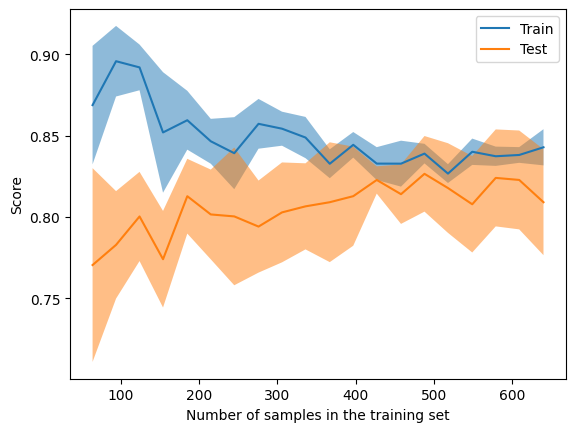

In [93]:
from sklearn.model_selection import LearningCurveDisplay

train_sizes, train_scores, test_scores = learning_curve(
    estimator=DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10, max_features=10),
    X=x_train_transformed,
    y=y_train,
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 20),
    scoring="accuracy"
)

tree_learning_curve = LearningCurveDisplay(train_sizes=train_sizes,
                                           train_scores=train_scores,
                                           test_scores=test_scores,
                                           score_name="Score").plot()
plt.show(tree_learning_curve)

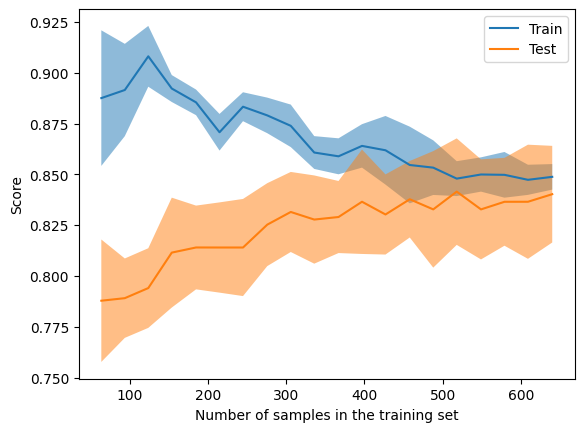

In [94]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=RandomForestClassifier(max_depth=5, max_leaf_nodes=10, max_features=10),
    X=x_train_transformed,
    y=y_train,
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 20),
    scoring="accuracy"
)

rfc_learning_curve = LearningCurveDisplay(train_sizes=train_sizes,
                                           train_scores=train_scores,
                                           test_scores=test_scores,
                                           score_name="Score").plot()
plt.show(rfc_learning_curve)

In [95]:
svc_pipeline = make_pipeline(preprocessing, SVC())
svc_pipeline[1:].get_params()

{'memory': None,
 'steps': [('svc', SVC())],
 'verbose': False,
 'svc': SVC(),
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf',
 'svc__max_iter': -1,
 'svc__probability': False,
 'svc__random_state': None,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False}

In [96]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'svc__C': randint(low=1, high=100),
    'svc__degree': randint(low=3, high=7),
    'svc__kernel': ['linear', 'poly', 'rbf'],
}

svc_random_search = RandomizedSearchCV(
    estimator=svc_pipeline,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring="accuracy"
)

svc_random_search.fit(x_train, y_train)
svc_rnd_srch_results = pd.DataFrame(svc_random_search.cv_results_)

In [97]:
svc_rnd_srch_results.sort_values(by="rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__C,param_svc__degree,param_svc__kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.040890,0.005833,0.021442,0.008140,2,4,rbf,"{'svc__C': 2, 'svc__degree': 4, 'svc__kernel':...",0.846442,0.842697,0.838951,0.842697,0.003058,1
9,0.048442,0.011794,0.021479,0.005292,23,3,poly,"{'svc__C': 23, 'svc__degree': 3, 'svc__kernel'...",0.838951,0.801498,0.820225,0.820225,0.015290,2
4,0.045299,0.004939,0.022919,0.004761,25,4,rbf,"{'svc__C': 25, 'svc__degree': 4, 'svc__kernel'...",0.827715,0.782772,0.816479,0.808989,0.019097,3


In [98]:
svc_random_search.best_params_

{'svc__C': 2, 'svc__degree': 4, 'svc__kernel': 'rbf'}

In [99]:
rfc_pipeline = make_pipeline(preprocessing, RandomForestClassifier())
rfc_pipeline[1:].get_params()

{'memory': None,
 'steps': [('randomforestclassifier', RandomForestClassifier())],
 'verbose': False,
 'randomforestclassifier': RandomForestClassifier(),
 'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__ccp_alpha': 0.0,
 'randomforestclassifier__class_weight': None,
 'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': None,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__max_leaf_nodes': None,
 'randomforestclassifier__max_samples': None,
 'randomforestclassifier__min_impurity_decrease': 0.0,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__min_weight_fraction_leaf': 0.0,
 'randomforestclassifier__monotonic_cst': None,
 'randomforestclassifier__n_estimators': 100,
 'randomforestclassifier__n_jobs': None,
 'randomforestclassifier__oob_score': False,
 'randomforestclassifier__random_state': None,
 'randomforestclassifier__verbose': 0,
 

In [100]:
param_dist = {
    'randomforestclassifier__max_depth': randint(low=2, high=20),
    'randomforestclassifier__max_leaf_nodes': randint(low=3, high=20),
    'randomforestclassifier__max_features': randint(low=2, high=20),
}

rfc_random_search = RandomizedSearchCV(
    estimator=rfc_pipeline,
    param_distributions=param_dist,
    n_iter=6,
    cv=3,
    scoring="accuracy"
)

rfc_random_search.fit(x_train, y_train)
rfc_rnd_srch_results = pd.DataFrame(rfc_random_search.cv_results_)

In [101]:
rfc_rnd_srch_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__max_features,param_randomforestclassifier__max_leaf_nodes,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.165168,0.000942,0.022198,0.004921,19,18,5,"{'randomforestclassifier__max_depth': 19, 'ran...",0.823970,0.831461,0.831461,0.828964,0.003531,3
1,0.171269,0.008610,0.022147,0.008389,9,16,6,"{'randomforestclassifier__max_depth': 9, 'rand...",0.823970,0.831461,0.831461,0.828964,0.003531,3
2,0.149354,0.000537,0.022173,0.006749,2,4,13,"{'randomforestclassifier__max_depth': 2, 'rand...",0.790262,0.805243,0.827715,0.807740,0.015392,6
3,0.183462,0.005087,0.021792,0.003819,13,19,12,"{'randomforestclassifier__max_depth': 13, 'ran...",0.831461,0.820225,0.842697,0.831461,0.009174,1
4,0.150080,0.000343,0.016589,0.000239,3,12,11,"{'randomforestclassifier__max_depth': 3, 'rand...",0.831461,0.831461,0.827715,0.830212,0.001766,2


In [102]:
rfc_random_search.best_params_

{'randomforestclassifier__max_depth': 13,
 'randomforestclassifier__max_features': 19,
 'randomforestclassifier__max_leaf_nodes': 12}

In [127]:
final_estimator = svc_random_search.best_estimator_
final_estimator

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=SimpleImputer(strategy='most_frequent'),
                                   transformers=[('sex',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['Sex']),
                                                 ('age_group',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('agegrouptransformer',
                                                                   AgeGroupTransformer...
                                                                                                 'PassengerId']))]),
                                                  ['Name', 'Ticket', 'SibSp',
                                                   'Parch', 'PassengerId']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Embarked']),
                                                 ('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Age'])])),
                ('svc', SVC(C=2, degree=4))])

In [128]:
final_estimator.score(x_test, y_test)

0.7

In [129]:
final_test = pd.read_csv("Data/test.csv")
final_test[final_test["Fare"].isna()]
final_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
final_test = pd.read_csv("../Data/test.csv")

final_test_preprocessed = preprocessing.fit_transform(final_test)
preprocessing.get_feature_names_out()

array(['sex__Sex_female', 'sex__Sex_male', 'age_group__AgeGroup_child',
       'age_group__AgeGroup_middle-adult', 'age_group__AgeGroup_senior',
       'age_group__AgeGroup_teen', 'age_group__AgeGroup_toddler',
       'age_group__AgeGroup_young-adult', 'family__Family', 'fare__Fare',
       'deck__Deck_A', 'deck__Deck_B', 'deck__Deck_C', 'deck__Deck_D',
       'deck__Deck_E', 'deck__Deck_F', 'deck__Deck_G', 'deck__Deck_N',
       'cat__Embarked_C', 'cat__Embarked_Q', 'cat__Embarked_S',
       'num__Age', 'remainder__Pclass'], dtype=object)

In [131]:
final_pipeline = make_pipeline(preprocessing, final_estimator)
final_survived = final_estimator.predict(final_test)

In [ ]:
submission = pd.DataFrame()
submission["PassengerId"] = final_test["PassengerId"]
submission["Survived"] = final_survived
submission = submission.reset_index(drop=True)
submission.to_csv("submission.csv", index=False)